In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import sys
from datetime import datetime, timedelta
from geopy.distance import geodesic
from scipy.optimize import curve_fit

import sympy as sym
from sympy.plotting import plot

In [2]:
all = pd.read_csv("./data/wholetime.csv")

/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_36321/1049815730.py:1: DtypeWarning: Columns (2,10) have mixed types. Specify dtype option on import or set low_memory=False.
  all = pd.read_csv("./data/wholetime.csv")


In [3]:
# Get the node_list, edge_list and timestamp
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return node_list, edge_list, timestamp

In [ ]:
class Fitting(object):
    def __init__(self):
        self.node_list, self.edge_list, self.timestamp = return_nm(all)
    
    def model1(self, m, kappa):
        Np = ((1 + np.sqrt(1 + ((32*m) / kappa))) / 2)
        return Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np) )
    
    

In [4]:
def model1(m, kappa):
    Np = ((1 + np.sqrt(1 + ((32*m) / kappa))) / 2)
    return Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np) )

In [5]:
all.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
0,41.9322,-87.6586,152.0,Lincoln Ave & Diversey Pkwy,2020-04-26 18:12:03,member,A847FADBBC638E45,docked_bike,41.8964,-87.6610,86,Eckhart Park,2020-04-26 17:45:14,3.981346,"(41.8964, -87.661)","(41.9322, -87.6586)"
1,41.9306,-87.7238,499.0,Kosciuszko Park,2020-04-17 17:17:03,member,5405B80E996FF60D,docked_bike,41.9244,-87.7154,503,Drake Ave & Fullerton Ave,2020-04-17 17:08:54,0.979629,"(41.9244, -87.7154)","(41.9306, -87.7238)"
2,41.8679,-87.6230,255.0,Indiana Ave & Roosevelt Rd,2020-04-01 18:08:36,member,5DD24A79A4E006F4,docked_bike,41.8945,-87.6179,142,McClurg Ct & Erie St,2020-04-01 17:54:13,2.984661,"(41.8945, -87.6179)","(41.8679, -87.623)"
3,41.8992,-87.6722,657.0,Wood St & Augusta Blvd,2020-04-07 13:02:31,member,2A59BBDF5CDBA725,docked_bike,41.9030,-87.6975,216,California Ave & Division St,2020-04-07 12:50:19,2.141375,"(41.903, -87.6975)","(41.8992, -87.6722)"
4,41.9695,-87.6547,323.0,Sheridan Rd & Lawrence Ave,2020-04-18 11:15:54,casual,27AD306C119C6158,docked_bike,41.8902,-87.6262,125,Rush St & Hubbard St,2020-04-18 10:22:59,9.119685,"(41.8902, -87.6262)","(41.9695, -87.6547)"


In [6]:
# データセットをいくつかのグループに分ける
df_p1 = all[(all['started_at'] >= '2020-03-01') & (all['started_at'] < '2020-06-01')]
df_p2 = all[(all['started_at'] >= '2020-06-01') & (all['started_at'] < '2020-11-01')]
df_p3 = all[(all['started_at'] >= '2020-11-01') & (all['started_at'] < '2021-03-01')]
df_p4 = all[(all['started_at'] >= '2021-03-01') & (all['started_at'] < '2023-10-01')]

In [ ]:
# node_list, edge_list, timestampを取得
node_list_p1, edge_list_p1, timestamp_p1 = return_nm(df_p1)
node_list_p2, edge_list_p2, timestamp_p2 = return_nm(df_p2)
node_list_p3, edge_list_p3, timestamp_p3 = return_nm(df_p3)
node_list_p4, edge_list_p4, timestamp_p4 = return_nm(df_p4)

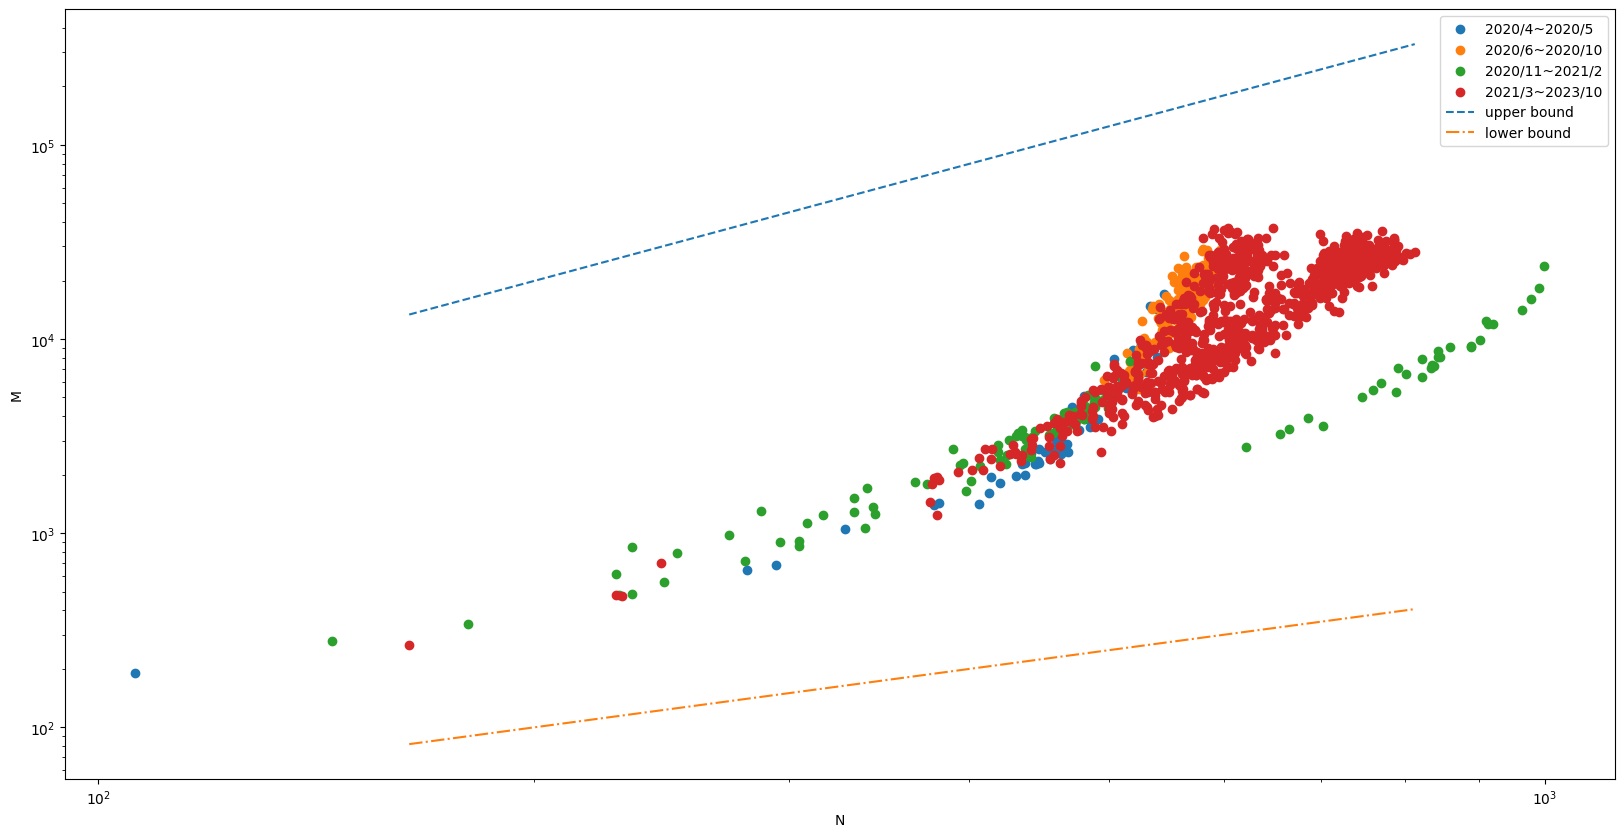

In [28]:
# 各node_list, edge_listをプロットする
# node_list_p1, node_list_p2, node_list_p3, node_list_p4の中で一番大きい値を含むリストを取得
node_list = [node_list_p1, node_list_p2, node_list_p3, node_list_p4]
node_list = max(node_list, key=len)

nn = len(node_list)
xmin = min(node_list)
xmax = max(node_list)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

plt.figure(figsize=(20, 10))
plt.scatter(node_list_p1, edge_list_p1, label='2020/4~2020/5')
plt.scatter(node_list_p2, edge_list_p2, label='2020/6~2020/10')
plt.scatter(node_list_p3, edge_list_p3, label='2020/11~2021/2')
plt.scatter(node_list_p4, edge_list_p4, label='2021/3~2023/10')
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


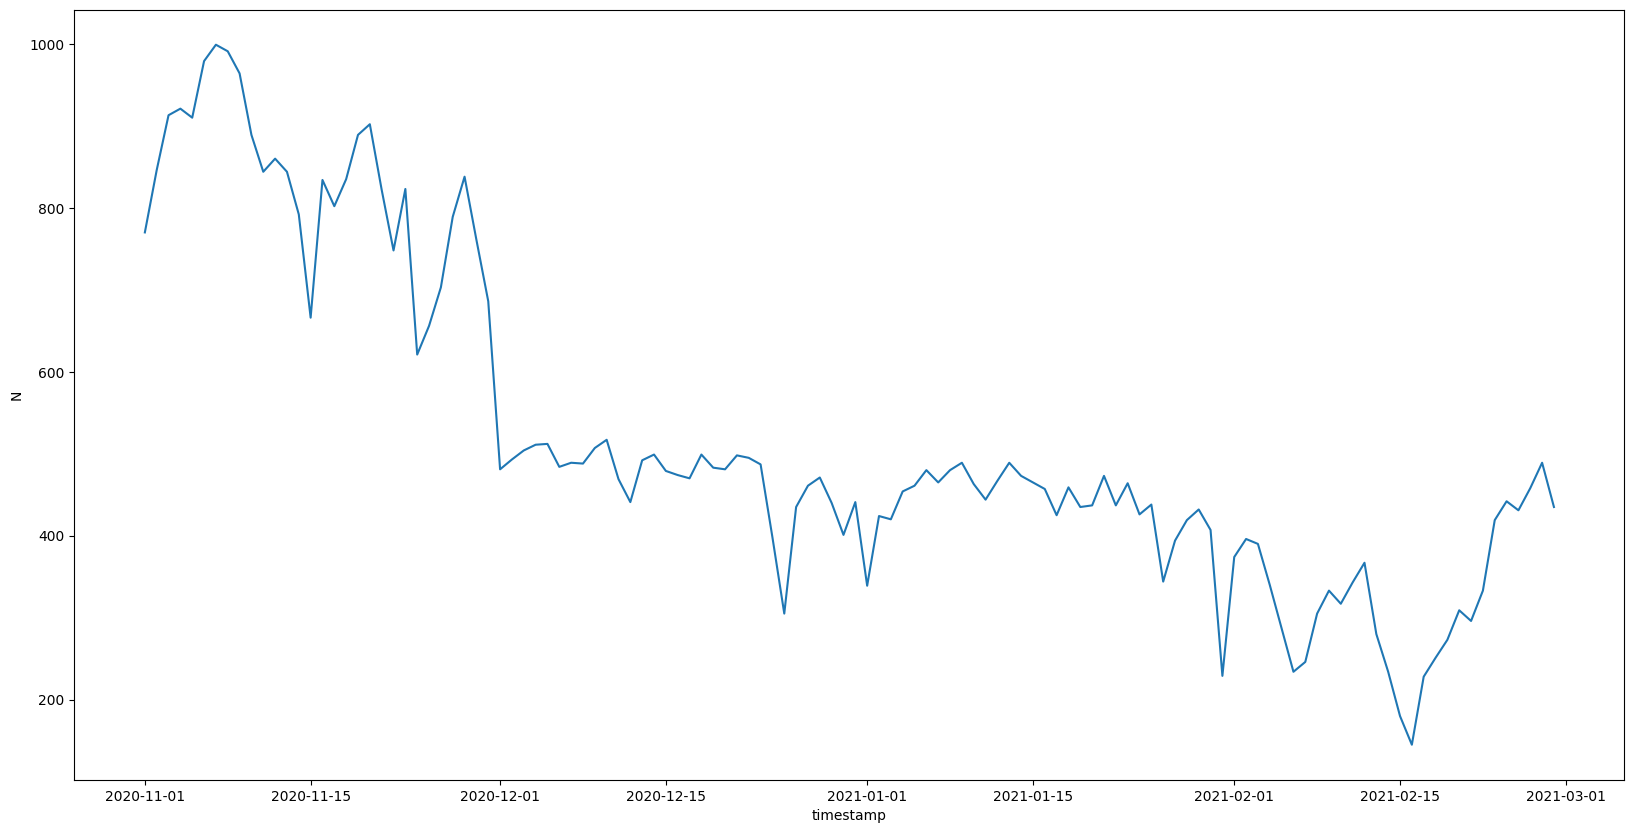

In [22]:
# timestamp_p3とnode_list_p3をプロット
plt.figure(figsize=(20, 10))
plt.plot(timestamp_p3, node_list_p3)
plt.xlabel('timestamp')
plt.ylabel('N')
plt.show()


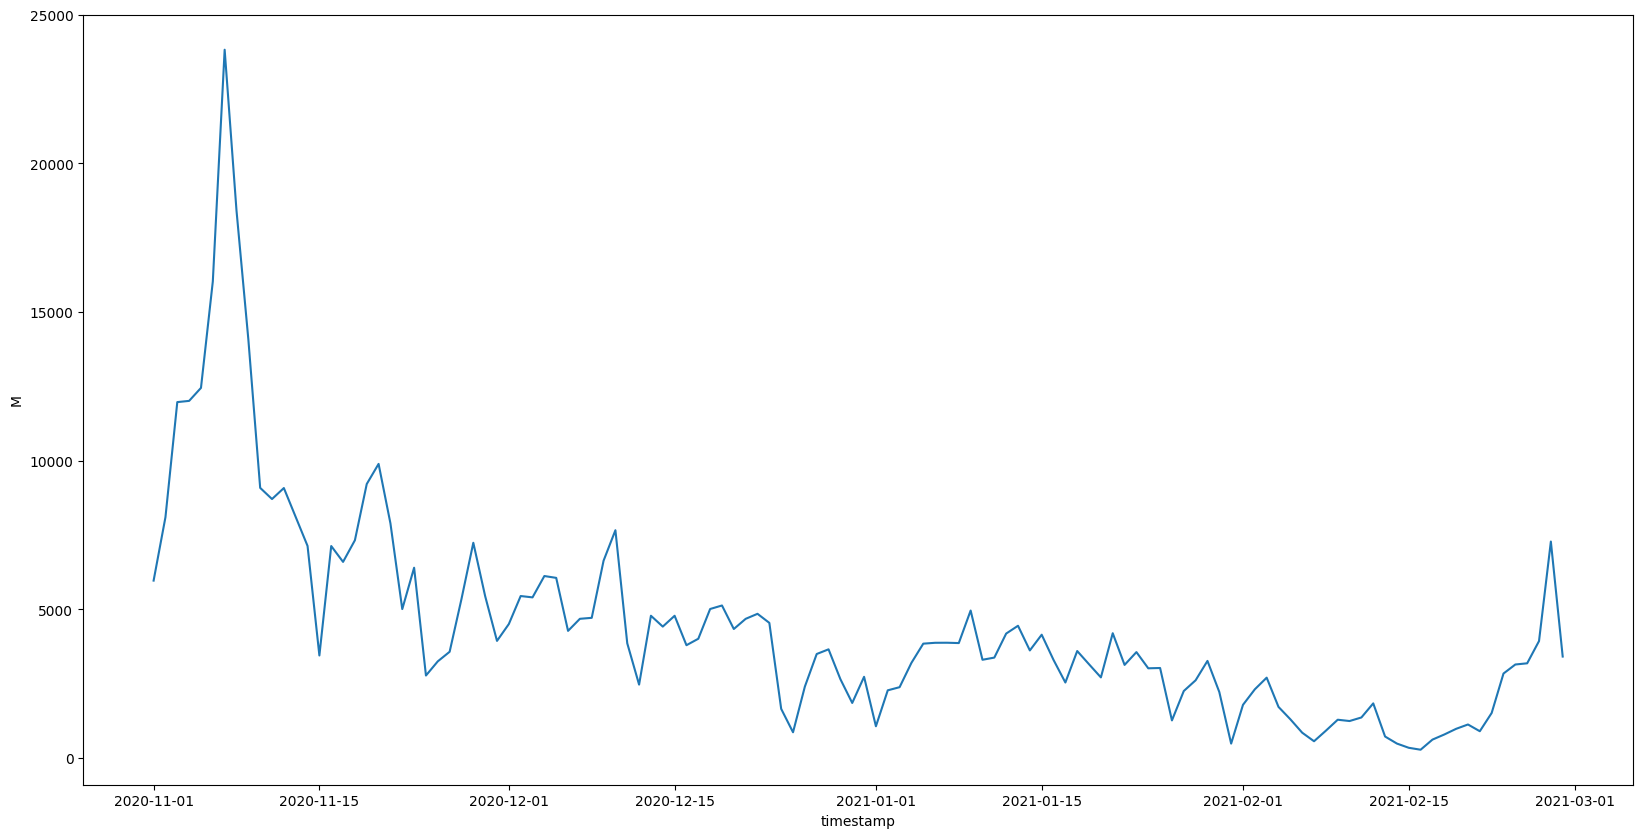

In [23]:
# timestamp_p3とedge_list_p3をプロット
plt.figure(figsize=(20, 10))
plt.plot(timestamp_p3, edge_list_p3)
plt.xlabel('timestamp')
plt.ylabel('M')
plt.show()


/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_36321/2462149829.py:2: RuntimeWarning: invalid value encountered in sqrt
  Np = ((1 + np.sqrt(1 + ((32*m) / kappa))) / 2)


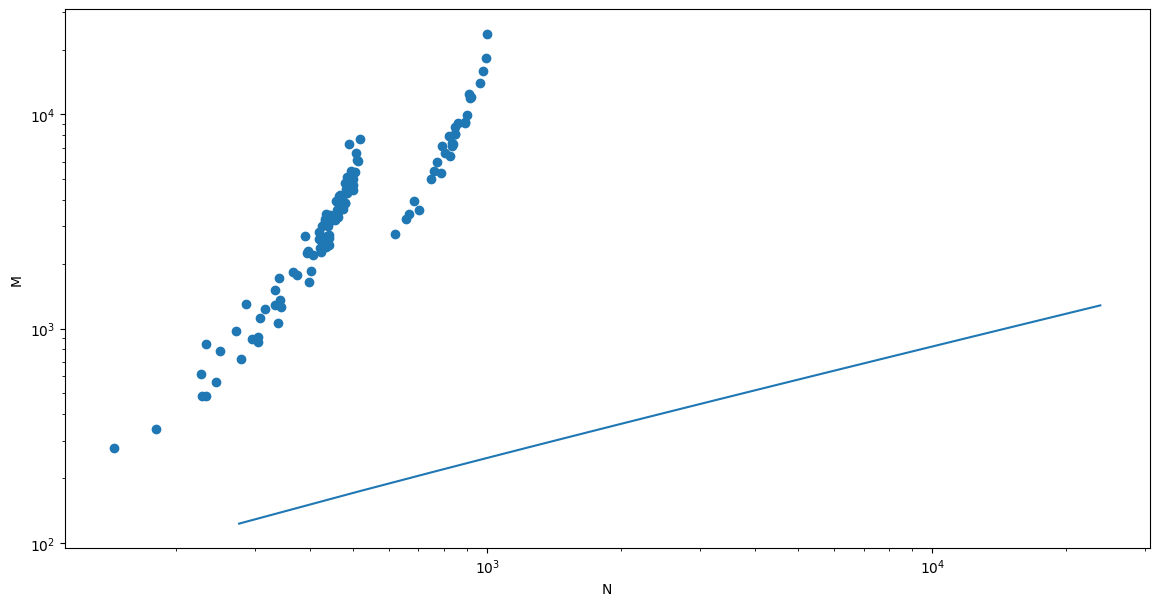

In [30]:
# node_list_p3とedge_list_p3をプロット
# カーブフィッティングする
params, cov = curve_fit(model1, edge_list_p3, node_list_p3)
x_curve = np.linspace(min(edge_list_p3), max(edge_list_p3), 100)
y_curve = model1(x_curve, params[0])


plt.figure(figsize=(14, 7))
plt.plot(x_curve, y_curve, label='curve fitting')
plt.scatter(node_list_p3, edge_list_p3)
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.show()


/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_36321/415920542.py:8: RuntimeWarning: invalid value encountered in power
  res = Np - ((Np ** 2 - Np))/4 * x * ((1 - (1 - ((4 * x) / (Np ** 2 - Np))) ** Np))


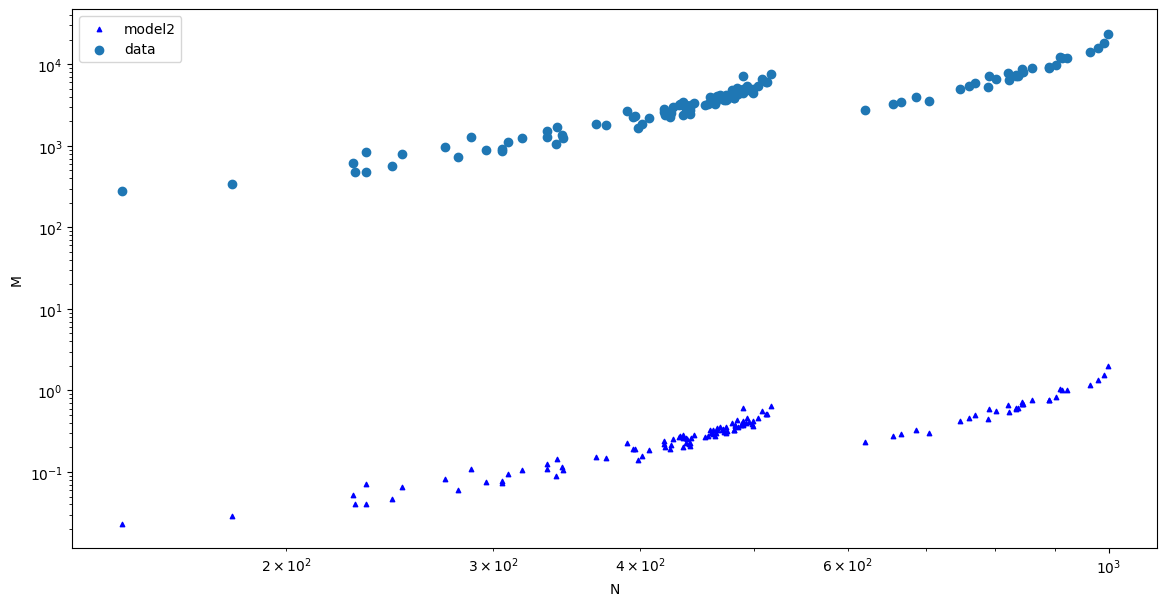

In [38]:
node_list = [x for x in node_list_p3 if x != 0]
edge_list = [x for x in edge_list_p3 if x != 0]

node_list = np.array(node_list)
edge_list = np.array(edge_list)

def model2(x, Np):
    res = Np - ((Np ** 2 - Np))/4 * x * ((1 - (1 - ((4 * x) / (Np ** 2 - Np))) ** Np))
    # resが0割りになってしまう場合があるので、その場合は0を返す
    if np.isnan(res.any()):
        res = 0
    if x.any() >= 0:
        return res
    else:
        return 0

params, cov = curve_fit(model2, edge_list, node_list, bounds=(0, [1000]))
Np = params[0]
x_curve = np.linspace(min(edge_list), max(edge_list), 100)
y_curve = model2(x_curve, params[0])

kappa = []
for i in range(len(edge_list)):
    kappa.append((8 * edge_list[i]) / (Np ** 2 - Np))
    
plt.figure(figsize=(14, 7))
# plt.plot(x_curve, y_curve, label='curve fitting')
plt.scatter(node_list, kappa, label="model2", marker="^", c="blue", s=10)
plt.scatter(node_list, edge_list, label='data')
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
